In [162]:
import pandas as pd
import os
base = 'C:/Users/bodil/Projects/Rick Journal Data/'
count = 0
for file_name in os.listdir(base + 'Data/'):
    if count == 0:
        df = pd.read_csv(base + 'Data/' + file_name, low_memory=False)
        count += 1
    else:
        df2 = pd.read_csv(base + 'Data/' + file_name, low_memory=False)
        df = df.append(df2)
        count += 1

In [164]:
df = df[df.articleType == 'Article'].copy()

In [166]:
# df = df[df.title == df.title].copy()

In [3]:
df = df[df.abstract == df.abstract].copy()

In [4]:
#remove copyright and other journal names from abstract
def remove_copyright_stuff(cell):
    remove_strings = [
        '© The Turkish Online Journal of Educational Technology. ',
        '© 2014 Elsevier Ltd. ',
        '© 2014, Springer Science+Business Media New York. ',
        ', Springer Science+Business Media Dordrecht. '
    ]
    for remove_string in remove_strings:
        if remove_string in cell[:len(remove_string) + 1]:
            cell = cell[len(remove_string):]
        if remove_string in cell[(len(cell) - len(remove_string)) - 1:]:
            cell = cell[:len(cell) - len(remove_string)]
    
    remove_strings7 = [
        'Elsevier Ltd. All rights reserved. ',
        'Elsevier B.V. All rights reserved. ',
        'Elsevier Ltd. ',
        'Taylor  &  Francis Group, LLC. ',
        'Taylor  &  Francis. ',
        'Association for Educational Communications and Technology. ',
        'British Educational Research Association'
    ]
    for remove_string in remove_strings7:
        if remove_string in cell[:len(remove_string) + 1 + 7]:
            cell = cell[len(remove_string) + 7:]
        if remove_string in cell[(len(cell) - len(remove_string) - 7 - 1):]:
            cell = cell[:len(cell) - len(remove_string) - 7]
    
    remove_strings4 = [
        '© ',
    ]
    for remove_string in remove_strings4:
        if remove_string in cell[:len(remove_string) + 1 + 4]:
            cell = cell[len(remove_string) + 4:]
        if remove_string in cell[(len(cell) - len(remove_string) - 4 - 1):]:
            cell = cell[:len(cell) - len(remove_string) - 4]
    
    return cell

In [5]:
df['abstract_new'] = df.abstract.map(remove_copyright_stuff)

In [6]:
def fix_abstract(cell):
    if cell.find('\xc2\xa9') != -1:
        start = cell.find('\xc2\xa9')
        end = cell.find('.',start)
        cell = cell[0:start] + cell[end:-1]
    else:
        pass
    cell = cell.lower()
    return cell

In [7]:
df['abstract_new'] = df['abstract_new'].map(fix_abstract)

In [8]:
special_chars = ['\xe2\x80\x9c','\xe2\x80\x9d']

In [9]:
import string
import re
punct = ' '
for x in string.punctuation:
    punct = punct + '|' + re.escape(x)

In [10]:
for x in special_chars:
    punct = punct + '|' + x

In [11]:
def split_words(cell):
    cell = re.split(punct,cell)
    return cell
df.abstract_new = df.abstract_new.map(split_words)

In [12]:
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))

In [13]:
def remove_punct(cell):
    new_cell = []
    for word in cell:
        if word in string.punctuation or word == ' ' or word in string.ascii_letters or word == '':
            pass
        elif word in stops:
            pass
        elif word[0] in '0123456789' or word[-1] in '0123456789':
            pass
        else:
            new_cell.append(word)
    return new_cell

In [14]:
df.abstract_new = df.abstract_new.map(remove_punct)

In [57]:
def abstract_word_counts(cell):
    return pd.Series(cell).value_counts()
df['word_counts'] = df.abstract_new.map(abstract_word_counts)

In [58]:
all_words = df.abstract_new.apply(pd.Series).stack().reset_index(drop=True)

In [59]:
total_words = all_words.value_counts().sum()

In [198]:
df.cluster_k_10.value_counts()

2    13739
9     6819
5     6078
6     5250
7     4713
8     4653
3     3140
1     2700
0     1107
4      953
Name: cluster_k_10, dtype: int64

In [206]:
final_positive = pd.DataFrame()
for x in range(10):
    differences = []
    temp = df[df.cluster_k_10 == x].title.map(lambda x: [y for y in x.lower().split(' ') if y not in stops]).apply(pd.Series).stack().reset_index(drop=True).value_counts()
    for y in range(10):
        if y == x:
            continue
        else:
            temp2 = df[df.cluster_k_10 == y].title.map(lambda x: [y for y in x.lower().split(' ') if y not in stops]).apply(pd.Series).stack().reset_index(drop=True).value_counts()
            difference = list((temp - temp2).sort_values(ascending=False).index[:20])
            differences = differences + difference
    final_positive[str(x)] = differences
    

In [226]:
fpos = pd.DataFrame()
for col in final_positive.columns:
    fpos[col] = final_positive[col].value_counts().index[:10]

In [227]:
fpos

,0:9,1:9,2:9,3:9,4:9,5:9,6:9,7:9,8:9,9:9
0,learner:,blog,online,information,contributing,knowledge,development,role,digital,use
1,outdoor,multi-user,student,another,targets,education,learning,technology,online,effects
2,operations,life:,social,extended,reviews:,teaching,design,effects,learning,online
3,individualized,components,technology,false,vs,technology,case,system,education,social
4,fixation,mobile,knowledge,avatar,ease,learning,technology,teaching,students',learning
5,rate,competencies,educational,education,colloquium,design,social,use,development,using
6,ethnographic,study,study,knowledge,collections:,students,educational,study,design,students
7,normal,teaching,using,repetition,choice,online,study,education,using,study
8,regarding,using,design,online,disclosure,distance,students,design,effects,education
9,aural,system,distance,use,talk,student,teaching,online,social,design


In [201]:
df[df.cluster_k_10 == 0].title.map(lambda x: [y for y in x.lower().split(' ') if y not in stops]).apply(pd.Series).stack().reset_index(drop=True).value_counts()

learning           236
education           75
online              72
study               67
using               61
effects             60
technology          54
use                 52
computer            49
design              48
social              48
teaching            47
students            44
development         43
approach            39
student             39
analysis            39
distance            36
digital             35
students'           35
educational         35
system              34
school              34
performance         33
case                33
environment         31
mobile              30
collaborative       30
instructional       28
effect              28
                  ... 
switch               1
related              1
suspicion            1
navidget             1
way?                 1
exercise?            1
adolescents,         1
smartphone           1
i:                   1
much                 1
apprehension         1
testing:             1
tandems    

In [124]:
cluster1 = df[df.cluster_k_5 == 0].title.map(lambda x: ).apply(pd.Series).stack().reset_index(drop=True).value_counts()
cluster2 = df[df.cluster_k_5 == 1].abstract_new.apply(pd.Series).stack().reset_index(drop=True).value_counts()
cluster3 = df[df.cluster_k_5 == 2].abstract_new.apply(pd.Series).stack().reset_index(drop=True).value_counts()
cluster4 = df[df.cluster_k_5 == 3].abstract_new.apply(pd.Series).stack().reset_index(drop=True).value_counts()
cluster5 = df[df.cluster_k_5 == 4].abstract_new.apply(pd.Series).stack().reset_index(drop=True).value_counts()

In [125]:
cluster1 = cluster1 / cluster1.sum()
cluster2 = cluster2 / cluster2.sum()
cluster3 = cluster3 / cluster3.sum()
cluster4 = cluster4 / cluster4.sum()
cluster5 = cluster5 / cluster5.sum()

# Cluster 1

In [159]:
final12 = cluster1 - cluster2
final12 = final12[final12 == final12]
final13 = cluster1 - cluster3
final13 = final13[final13 == final13]
final14 = cluster1 - cluster4
final14 = final14[final14 == final14]
final15 = cluster1 - cluster5
final15 = final15[final15 == final15]
pd.Series(list(final12.sort_values(ascending=False)[:20].index) + list(final13.sort_values(ascending=False)[:20].index) + list(final14.sort_values(ascending=False)[:20].index) + list(final15.sort_values(ascending=False)[:20].index)).value_counts()

course         4
research       3
students       3
design         3
learning       3
education      3
educational    2
students’      2
teachers       2
assessment     2
open           2
technology     2
paper          2
results        2
online         2
digital        2
group          2
study          2
visual         1
teachers’      1
engagement     1
university     1
based          1
words          1
number         1
users          1
frequency      1
media          1
practice       1
content        1
society        1
psychonomic    1
article        1
inc            1
data           1
use            1
teaching       1
recall         1
process        1
skills         1
self           1
mobile         1
experiment     1
subjects       1
program        1
school         1
development    1
influence      1
word           1
work           1
elsevier       1
ltd            1
global         1
game           1
learners       1
dtype: int64

# Cluster 2

In [158]:
final21 = cluster2 - cluster1
final21 = final21[final21 == final21]
final23 = cluster2 - cluster3
final23 = final23[final23 == final23]
final24 = cluster2 - cluster4
final24 = final24[final24 == final24]
final25 = cluster2 - cluster5
final25 = final25[final25 == final25]
pd.Series(list(final21.sort_values(ascending=False)[:20].index) + list(final23.sort_values(ascending=False)[:20].index) + list(final24.sort_values(ascending=False)[:20].index) + list(final25.sort_values(ascending=False)[:20].index)).value_counts()

learners        4
learning        4
group           4
technology      4
educational     4
students        4
research        3
teachers        3
university      3
education       3
technologies    3
course          2
media           2
open            2
study           2
online          2
library         2
design          2
school          2
libraries       1
practice        1
text            1
beliefs         1
teacher         1
assessment      1
support         1
article         1
environment     1
francis         1
information     1
development     1
teaching        1
groups          1
students’       1
self            1
mobile          1
level           1
authors         1
academic        1
based           1
digital         1
strategies      1
content         1
one             1
dtype: int64

# Cluster 3

In [160]:
final31 = cluster3 - cluster1
final31 = final31[final31 == final31]
final32 = cluster3 - cluster2
final32 = final32[final32 == final32]
final34 = cluster3 - cluster4
final34 = final34[final34 == final34]
final35 = cluster3 - cluster5
final35 = final35[final35 == final35]
pd.Series(list(final31.sort_values(ascending=False)[:20].index) + list(final32.sort_values(ascending=False)[:20].index) + list(final34.sort_values(ascending=False)[:20].index) + list(final35.sort_values(ascending=False)[:20].index)).value_counts()

ltd            3
experiment     3
rights         3
elsevier       3
effects        3
effect         3
words          3
reserved       3
recognition    3
subjects       3
memory         3
experiments    3
computer       3
psychonomic    3
©              3
recall         3
results        3
word           2
information    2
society        2
learning       1
course         1
study          1
educational    1
practice       1
task           1
technology     1
knowledge      1
learners       1
media          1
two            1
strategies     1
digital        1
assessment     1
children       1
design         1
based          1
online         1
well           1
education      1
inc            1
students       1
motivation     1
dtype: int64

In [15]:
df['abstract_new2'] = df.abstract_new.map(lambda x: ' '.join(x))

In [167]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(df['title'])

In [168]:
df.title.count()

49152

In [61]:
# import math
# import random
# import operator
# import itertools

# def dot_product2(v1, v2):
#     return sum(map(operator.mul, v1, v2))

# def vector_cos5(v1, v2):
#     prod = dot_product2(v1, v2)
#     len1 = math.sqrt(dot_product2(v1, v1))
#     len2 = math.sqrt(dot_product2(v2, v2))
#     return prod / (len1 * len2)

In [169]:
import numpy as np
np.shape(x)

(49152, 19834)

In [170]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(x)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

Explained variance of the SVD step: 20%


In [193]:
from sklearn.cluster import KMeans
from sklearn import metrics
elbow_plot = []
for x in range(1,100):
    km = KMeans(n_clusters=x, init='k-means++', max_iter=100, n_init=1, random_state=0)
    result = km.fit(X)
    elbow_plot.append(result.inertia_)
    print(x)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76


KeyboardInterrupt: 

In [194]:
%matplotlib inline
from matplotlib import pyplot as plt

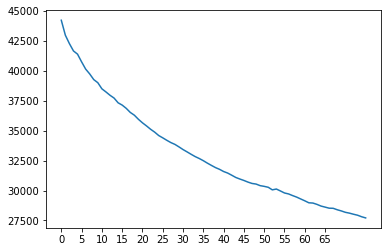

In [195]:
import numpy as np
plt.xticks(np.arange(0,70,5))
plt.plot(elbow_plot)

In [ ]:
#3 choices for correct number of clusters
#5 clusters
#27 clusters
#55 clusters

In [196]:
from sklearn.cluster import KMeans
from sklearn import metrics
num_of_clusters = 10
km = KMeans(n_clusters=num_of_clusters, init='k-means++', max_iter=100, n_init=1, random_state=0)
result = km.fit(X)

In [197]:
#CLUSTER SEPARATION BY JOURNAL

df['cluster_k_10'] = pd.Series(result.labels_)
test = df[['publicationName','cluster_k_5']].copy()
test['test'] = test.publicationName.astype(str) + test.cluster_k_5.astype(str)
test.test.value_counts()

Computers in Human Behavior4                                                       2111
Computers and Education4                                                           1766
Memory and Cognition4                                                              1205
British Journal of Educational Technology4                                          955
Computers in Human Behavior2                                                        951
Computers in Human Behavior3                                                        943
Turkish Online Journal of Educational Technology4                                   813
Computers and Education3                                                            804
Computers and Education2                                                            769
International Journal of Human Computer Studies4                                    760
Memory &amp; Cognition4                                                             751
International Journal of Learnin

# Tabular Inspection

In [191]:
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
for cluster in range(2,3):
    temp = df[df.cluster_k_5 == cluster]
    cluster_words = temp.title.map(lambda x: [y for y in x.lower().split(' ') if y not in stops]).apply(pd.Series).stack().reset_index(drop=True)

In [192]:
cluster_words.value_counts()

learning            2374
online               856
education            731
study                650
using                596
use                  585
technology           575
social               517
effects              515
design               487
students             453
teaching             415
development          400
student              397
students'            382
computer             378
knowledge            355
educational          342
case                 332
school               322
digital              311
system               310
distance             309
analysis             304
information          303
virtual              296
model                271
collaborative        270
performance          267
mobile               267
                    ... 
tactics:               1
balked                 1
vitro                  1
expanded               1
inquiry"               1
graduating             1
abilities,             1
meta-game              1
thesaurus-based        1


In [48]:
cluster_words.value_counts()

learning        21722
students        16537
study           12714
use              8213
©                7751
based            7490
results          7293
research         7289
technology       6466
education        6235
online           6131
design           5819
paper            5595
knowledge        5317
used             5308
using            5270
information      5168
two              4931
teachers         4836
group            4705
social           4665
data             4652
also             4377
teaching         4246
student          4232
computer         4206
educational      4142
model            4029
system           3906
analysis         3795
                ...  
eli                 1
studentski          1
combatant           1
‘open’              1
viten               1
schrum              1
adoptedin           1
stubbs              1
cctv                1
pearlstone          1
unitelma            1
eurvine             1
cho                 1
davey               1
playroom  

In [ ]:
#VISUAL INSPECTION BELOW

In [32]:
final_df = pd.DataFrame()
count = 1

for x in range(num_of_clusters):
    x = float(x)
    temp = df[df.cluster_k_5 == x]
    x = int(x)
    temp_counts = temp.abstract.apply(pd.Series).stack().reset_index(drop=True).value_counts()
    temp_counts = temp_counts/float(len(temp.index))
    temp_counts_df = pd.DataFrame(temp_counts)
    temp_counts_df['words'] = temp_counts_df.index
    temp_counts_df.reset_index(inplace=True,drop=True)
    temp_counts_df.rename(columns={0:'counts{}'.format(x + 1)},inplace=True)
    if count == 1:
        final_df = temp_counts_df.copy()
    else:
        final_df = final_df.merge(temp_counts_df,on='words',how='outer')
    count += 1

In [38]:
import matplotlib

In [1]:
num_to_show = 100
fig, ax = plt.subplots(figsize=(num_to_show, 10))

ind = np.arange(num_to_show)  # the x locations for the groups
width = 5 / num_of_clusters
colors = list(matplotlib.colors.cnames.keys())
for x in range(num_of_clusters):
    rects1 = ax.bar(ind + width*x, list(final_df['counts{}'.format(x+1)][:num_to_show]/float(len(final_df.index))),width,color=colors[x])
ax.set_xticklabels(final_df.words[:num_to_show])
ax.set_xticks(ind + .33)